# Information Retrieval and Web Analytics
# PROJECT PART 2: Indexing and Evaluation

Gerard Morales - NIA: 242781

Patricia Garay - NIA: 229260

Maren Clapers - NIA: 243397


In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Python packages

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 733.7 kB/s eta 0:00:00


In [5]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
from nltk.tokenize import word_tokenize
import time
import json
import pandas as pd
import string
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import demoji
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE

## Documents and Tweets mapping

In [6]:
#Update the path:
docs_path = '/content/drive/Shared drives/RIAW/Project/Part1/IRWA_data_2023/Rus_Ukr_war_data.json'

# Open and read the json file
with open(docs_path, 'r') as file:
    data = file.read()

# Split the content into individual JSON objects
# Each JSON object must be on a separate line
lines = data.strip().split('\n')

# Tweets dictionary identified by ID
tweets_dict = {}

for line in lines:
    tweet = json.loads(line)
    tweet_id = tweet['id']

    # For each tweet: Tweet | Date | Hashtags | Likes | Retweets | Url
    tweet_info = {
        "tweet_id": tweet_id,
        "tweet": tweet.get("full_text", ""),
        "date": tweet.get("created_at", ""),
        "hashtags": [tag["text"] for tag in tweet["entities"]["hashtags"]],
        "likes": tweet.get("favorite_count", 0), # 0 is the default value in case it does not exist
        "retweets": tweet.get("retweet_count", 0),
        "url": tweet['entities']['media'][0]['expanded_url'] if 'media' in tweet['entities'] else ""
    }

    tweets_dict[tweet_id] = tweet_info

In [7]:
# Convert data into a DataFrame with Tweet | Date | Hashtags | Likes | Retweets | Url
tweets_list = list(tweets_dict.values())
tweets_df = pd.DataFrame(tweets_list)

In [8]:
original_df = tweets_df.copy()

In [9]:
def build_terms(line):
    """
    Preprocess the tweets by removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    tokens - a list of tokens corresponding to the input text after the preprocessing
    """
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    # Remove URLs using a regular expression
    line = re.sub(r'http\S+|www\S+|https\S+', '', line)

    # Replace special characters
    line = line.replace('’', ' ').replace('“', ' ').replace('”', ' ').replace('‘', '')

    line = line.lower()  # Transform in lowercase
    line = demoji.replace(line, '')  # Remove emojis

    # Tokenize the text while preserving hashtags
    tokens = re.findall(r'\w+|#\w+', line)

    # Remove punctuation from words (excluding hashtags)
    tokens = [re.sub(r'[{}]'.format(string.punctuation), '', token) if not token.startswith('#') else token for token in tokens]

    tokens = [w for w in tokens if w not in stop_words]  # Eliminate stopwords
    tokens = [stemmer.stem(w) for w in tokens]  # Perform stemming

    return tokens

In [10]:
## Apply the build_terms() function to the tweets of the dataFrame
tweets_df['tweet'] = tweets_df['tweet'].apply(build_terms)
## Convert 'Date' to a pandas datetime object
tweets_df['date'] = pd.to_datetime(tweets_df['date'])

In [11]:
#Update the path:
docs_id_path = '/content/drive/Shared drives/RIAW/Project/Part1/IRWA_data_2023/Rus_Ukr_war_data_ids.csv'
tweet_document_ids = pd.read_csv(docs_id_path, sep='\t', header=None, names=['document_id', 'tweet_id'])
tweet_document_ids_df = pd.DataFrame(tweet_document_ids)
tweet_document_ids_df

,document_id,tweet_id
0,doc_1,1575918221013979136
1,doc_2,1575918081461080065
2,doc_3,1575917992390823936
3,doc_4,1575917907774967809
4,doc_5,1575917878410301441
...,...,...
3995,doc_3996,1575154617620504576
3996,doc_3997,1575154444165156864
3997,doc_3998,1575154440012812288
3998,doc_3999,1575154351273873410


In [12]:
## Joining the dataframes 'tweets_df' and 'tweet_document_ids_df'
tweets_df = pd.merge(tweets_df, tweet_document_ids_df, how='inner', on='tweet_id')
tweets_df.head()

,tweet_id,tweet,date,hashtags,likes,retweets,url,document_id
0,1575918221013979136,"[melsimmonsfcdo, wrong, dictat, putin, fascist...",2022-09-30 18:39:17+00:00,"[RussiainvadesUkraine, UkraineRussiaWar]",0,0,,doc_1
1,1575918081461080065,"[arm, forc, liber, villag, #drobyshev, #lymans...",2022-09-30 18:38:44+00:00,"[Drobysheve, Lymansk, Donetsk, UkraineRussiaWa...",0,0,https://twitter.com/Feher_Junior/status/157591...,doc_2
2,1575917992390823936,"[alert, poland, prep, anti, radiat, tablet, nu...",2022-09-30 18:38:23+00:00,"[NATO, Putin, Russia, RussiaInvadedUkraine, Uk...",0,0,,doc_3
3,1575917907774967809,"[still, wait, googl, map, updat, russia, new, ...",2022-09-30 18:38:03+00:00,"[Putin, UkraineRussiaWar]",0,0,,doc_4
4,1575917878410301441,"[emmanuelmacron, probabl, right, say, anyway, ...",2022-09-30 18:37:56+00:00,"[European, UkraineRussiaWar]",0,0,,doc_5


# PART 2: Indexing and Evaluation

## Ranking results using TF-IDF


In [13]:
#Rank your results: Implement the TF-IDF algorithm and provide ranking based results.

Function to implement the inverted index and compute tf, df and idf:

In [14]:
def create_index_tfidf(lines, num_tweets):
    """
    Implement the inverted index and compute tf, df and idf

    Argument:
    lines -- collection of tweets
    num_tweets -- total number of tweets

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of tweets these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each tweets
    df - number of tweets each term appear in
    idf - inverse tweet frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list) # term frequencies of terms in tweets
    df = defaultdict(int) # tweet frequencies of terms in the corpus
    tweet_id_index = dict(zip(lines['tweet_id'], lines['tweet'])) #dictionary with tweet ids and the tweets' text
    idf = defaultdict(float)

    for id, row in lines.iterrows(): #iterates through tweets dataframe

        tweet_id = row['tweet_id']
        tweet_text = row['tweet']
        terms = tweet_text

        current_tweet_index = {}

        for position, term in enumerate(terms): # terms contains tweet_text. Loops over all terms:
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_tweet_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_tweet_index[term]=[tweet_id, array('I',[position])]

        #normalize term frequencies
        norm = 0
        for term, posting in current_tweet_index.items():
            # posting will contain the list of positions for current term in current tweet.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term_tweet, posting_tweet in current_tweet_index.items():
            # append the tf for current term (tf = term frequency in current tweet/norm)
            tf[term_tweet].append(np.round(len(current_tweet_index[term_tweet])/norm,4))
            #increment the tweet frequency of current term (number of tweets containing the current term)
            df[term_tweet] += 1

        #merge the current page index with the main index
        for term_tweet, posting_tweet in current_tweet_index.items():
            index[term_tweet].append(posting_tweet)

        # Compute IDF
        for term in df:
            idf[term] = np.round(np.log(float(num_tweets/df[term])), 4)

    return index, tf, df, idf, tweet_id_index

In [15]:
lines = tweets_df
num_tweets = len(tweets_df)

start_time = time.time()
index, tf, df, idf, tweet_id_index = create_index_tfidf(lines, num_tweets)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 246.29 seconds


Function to perform the ranking of the results of a search based on the tf-idf weights:

In [16]:
def rank_documents(terms, tweets, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    tweets -- list of tweets, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies

    Returns:
    Print the list of ranked documents
    """

    # We are interested only on the element of the docVector corresponding to the query terms
    tweet_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=query_terms_count[term]/query_norm*idf[term]


        # Generate tweet_vectors for matching tweets
        for tweet_index, (tweet, postings) in enumerate(index[term]):
            if tweet in tweets:
              tweet_vectors[tweet][termIndex] = tf[term][tweet_index] * idf[term]

    # Calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    tweet_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in tweet_vectors.items() ]
    tweet_scores.sort(reverse=True)
    result_tweets = [x[1] for x in tweet_scores]
    tweet_scores= [x[0] for x in tweet_scores]

    if len(result_tweets) == 0:
        print("No results found, try again")
        query = input()
        tweets = search_tf_idf(query, index)

    return result_tweets, tweet_scores

Function to get the list of documents that contain any of the query terms:

In [17]:
def search_tf_idf(query, index):
    """
    output is the list of tweets that contain any of the query terms.
    So, we will get the list of tweets for each query term, and take the union of them.
    """
    query = build_terms(query)
    tweets = set()
    for term in query:
        try:
            # store in term_tweets the ids of the tweets that contain "term"
            term_tweets=[posting[0] for posting in index[term]]

            # tweets = tweets Union term_tweets
            tweets = tweets.union(term_tweets)
        except:
            #term is not in index
            pass
    tweets = list(tweets)
    ranked_tweets, tweet_scores = rank_documents(query, tweets, index, idf, tf)
    return ranked_tweets, tweet_scores

### Queries


#### Query 1:


In [18]:
query1 = 'Presidents visiting Kyiv'
ranked_tweets, tweet_scores = search_tf_idf(query1, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_tweets)))
count = 1
for t_id in ranked_tweets[:top]:
    original_tweet = original_df[original_df['tweet_id'] == t_id]
    print('Tweet {}:'.format(count))
    print("Tweet_id = {}\nTweet text: {}\n".format(t_id, original_tweet['tweet'].values[0]))

    count += 1


Top 10 results out of 125 for the searched query:

Tweet 1:
Tweet_id = 1575768808337412098
Tweet text: #UkraineRussiaWar #UK #UnitedKingdom #GreatBritain #Kyiv #SupportUkraine #StandWithUkraine British defense minister paid secret visit to Kyiv this week https://t.co/AyeLy3StYb

Tweet 2:
Tweet_id = 1575827125159940096
Tweet text: Russian President Putin calls on Kyiv to 'immediately' cease military action 
https://t.co/duGzYIEnuR 
#Putin #Russian #UkraineRussiaWar https://t.co/xMaaRgA5Hw

Tweet 3:
Tweet_id = 1575827101030064128
Tweet text: #UkraineRussiaWar | Russian President Vladimir Putin calls on Kyiv to 'immediately' cease military action | reported by news agency AFP

Tweet 4:
Tweet_id = 1575511622302695425
Tweet text: Clown Steven Seagal visits injured Russian soldiers in hospital.
#Russian #Russia #Ukraine #Ukrainian #UkraineWar #UkraineRussiaWar #RussiaIsATerroristState https://t.co/lN4ZWr7QAI

Tweet 5:
Tweet_id = 1575905170952982529
Tweet text: ⚡️BREAKING: After Putin's unil

#### Query 2:

In [19]:
query2 = 'Countries supporting Ukraine'
ranked_tweets, tweet_scores = search_tf_idf(query2, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_tweets)))
count = 1
for t_id in ranked_tweets[:top]:
    original_tweet = original_df[original_df['tweet_id'] == t_id]
    print('Tweet {}:'.format(count))
    print("Tweet_id = {}\nTweet text: {}\n".format(t_id, original_tweet['tweet'].values[0]))

    count += 1


Top 10 results out of 1034 for the searched query:

Tweet 1:
Tweet_id = 1575159106356203523
Tweet text: What about our ability to defense our country??? #UkraineRussiaWar 
https://t.co/zCnIPPU3sU

Tweet 2:
Tweet_id = 1575669419551862784
Tweet text: No fly zones, loss of overseas Russian assets with financial compensation to Ukraine, with increased support from countries on the side lines atm.
#Ukraine #UkraineWar #UkrainianArmy #UkraineRussiaWar #UkraineWillWin #Russia #Russian #RussianArmy https://t.co/YIr358oh2z

Tweet 3:
Tweet_id = 1575784366957301760
Tweet text: #DOPPELGANGER: How Russia-based actors cloned legitimate media outlets from multiple countries (🇩🇪🇬🇧🇫🇷🇮🇹🇱🇻🇺🇦) to spread #disinformation designed to undermine the support for #Ukraine. #UkraineRussiaWar 

@DisinfoEU last investigation: https://t.co/lydkTWOgW6

Tweet 4:
Tweet_id = 1575206589287452672
Tweet text: @Google why #ukraine language is not supported? #UkraineRussiaWar https://t.co/dEvBOpa8JK

Tweet 5:
Tweet_id = 157

#### Query 3:

In [20]:
query3 = 'Humanitarian aid in Ukraine'
ranked_tweets, tweet_scores = search_tf_idf(query3, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_tweets)))
count = 1
for t_id in ranked_tweets[:top]:
    original_tweet = original_df[original_df['tweet_id'] == t_id]
    print('Tweet {}:'.format(count))
    print("Tweet_id = {}\nTweet text: {}\n".format(t_id, original_tweet['tweet'].values[0]))

    count += 1


Top 10 results out of 937 for the searched query:

Tweet 1:
Tweet_id = 1575764098260029440
Tweet text: The people in the convoy had planned to travel to the Russian-occupied part of #Zaporizhzhia to pick up their relatives and deliver humanitarian aid.
#RussianUkrainianWar #Ukraine #StandWithUkraine #civiliancasualties #UkraineRussiaWar #UkraineCrisis #PutinWarCriminal https://t.co/IKbZRk6dTH

Tweet 2:
Tweet_id = 1575722456823738370
Tweet text: ❗Russian missile attack on the humanitarian convoy from Zaporizhzhia to occupied territories. People were heading to rescue their relatives left in russia-controlled areas and provide humanitarian aid.

#UkraineRussiaWar https://t.co/ZlYntJRliA

Tweet 3:
Tweet_id = 1575757996663377920
Tweet text: 30.09.22.
Zaporizhzhia, Ukraine. 

Those people are volunteers who wanted to give some humanitarian aid for people there and leave town with their relatives. But russia had another plan. 

#russiaisateroriststate #RussiaIsANaziState #Zaporizhzhia #Ukra

#### Query 4:

In [21]:
query4 = 'Citizens fleeing Ukraine'
ranked_tweets, tweet_scores = search_tf_idf(query4, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_tweets)))
count = 1
for t_id in ranked_tweets[:top]:
    original_tweet = original_df[original_df['tweet_id'] == t_id]
    print('Tweet {}:'.format(count))
    print("Tweet_id = {}\nTweet text: {}\n".format(t_id, original_tweet['tweet'].values[0]))

    count += 1


Top 10 results out of 974 for the searched query:

Tweet 1:
Tweet_id = 1575677477460275200
Tweet text: I have been hearing that thousands of Russian men fleeing to Mongolia 🇲🇳. #UkraineRussiaWar https://t.co/Dz9P48CuIV

Tweet 2:
Tweet_id = 1575688594530115586
Tweet text: Russia bombing innocent citizens.
This must stop.
#UkraineRussiaWar https://t.co/esEBivfx2A

Tweet 3:
Tweet_id = 1575180780568924160
Tweet text: Lukashenko is advising Putin not to worry about those fleeing mobilization: 
#Russia #UkraineRussiaWar #Belarus https://t.co/Lu55nrfphL

Tweet 4:
Tweet_id = 1575749242412761089
Tweet text: #UkraineRussiaWar #Ukraine #Russia

🌐 Social media
Russians forces reportedly flees from #Lyman https://t.co/q59JOGhM9E

Tweet 5:
Tweet_id = 1575639975567073280
Tweet text: Opinion | Russians flee as Putin announces Ukraine annexation - The Washington Post https://t.co/zFZnMnLdlV #Ukraine  #UkraineRussiaWar #UkraineUnderAttack #UkraineWarNews

Tweet 6:
Tweet_id = 1575517390724538372
Tweet t

#### Query 5:

In [22]:
query5 = 'Putin and Zelensky peace talks'
ranked_tweets, tweet_scores = search_tf_idf(query5, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_tweets)))
count = 1
for t_id in ranked_tweets[:top]:
    original_tweet = original_df[original_df['tweet_id'] == t_id]
    print('Tweet {}:'.format(count))
    print("Tweet_id = {}\nTweet text: {}\n".format(t_id, original_tweet['tweet'].values[0]))

    count += 1


Top 10 results out of 591 for the searched query:

Tweet 1:
Tweet_id = 1575916840286507009
Tweet text: I don’t recall all of this peace/truce talk when people thought Russia was winning. #UkraineRussiaWar

Tweet 2:
Tweet_id = 1575906959450337281
Tweet text: ⚡️Zelensky rules out peace talks following Moscow’s annexation of huge swathes of four Ukrainian regions.
There's no way to peace talking with a terrorist State
https://t.co/aRQwsKpZlL

#WARINUKRAINE #UKRAINEWAR #UKRAINERUSSIAWAR #UKRAINE https://t.co/ci9f159F7D

Tweet 3:
Tweet_id = 1575824812835950592
Tweet text: BREAKING: Putin says "We are ready for talks" 

#UkraineRussiaWar

Tweet 4:
Tweet_id = 1575169966126800896
Tweet text: As you can see, Azerbaijan's peace talks with Armenia are not yielding any results.- @ChairOlek

@ElnurMammadli1 
#UkraineRussiaWar #RussianArmy #PutinWarCriminal #UkraineInvasion https://t.co/sgSkbszv8g

Tweet 5:
Tweet_id = 1575908651658641408
Tweet text: ⚡️"#Ukraine is ready to talk with Russia, but onl

## Evaluation

In [23]:
# loading the Evaluation_gt.csv file (Update the path to match yours)
evaluation_gt_path = '/content/drive/Shared drives/RIAW/Project/Part2/Evaluation_gt.csv'
evaluation_gt = pd.read_csv(evaluation_gt_path, sep=',')
evaluation_gt_df = pd.DataFrame(evaluation_gt)

#transform query_id from Q1,Q2,Q3 to 1,2,3
evaluation_gt_df['query_id'] = evaluation_gt_df['query_id'].str[1:].astype(int)
evaluation_gt_df.head()

,doc,query_id,label
0,doc_2052,3,1
1,doc_164,3,1
2,doc_411,3,1
3,doc_1805,3,1
4,doc_3442,3,1


In [24]:
# adding the 'is_relevant' and 'tweet_id' columns
search_results = evaluation_gt_df
search_results.rename(columns={'label': 'is_relevant'}, inplace=True)
search_results.rename(columns={'doc': 'document_id'}, inplace=True)
search_results = pd.merge(search_results, tweets_df[['document_id', 'tweet_id']], on='document_id', how='inner')
search_results.head()

,document_id,query_id,is_relevant,tweet_id
0,doc_2052,3,1,1575579616689139712
1,doc_164,3,1,1575900609240215553
2,doc_411,3,1,1575861425133981696
3,doc_1805,3,1,1575633135190290432
4,doc_3442,3,1,1575226859645960192


In [25]:
#Baseline queries --> Information needed:
baseline_queries = ['tank in Kharkiv', 'Nord Stream pipeline', 'annexation of territories by Russia']
predicted_relevance = []

for pos, row in search_results.iterrows():
  ranked_tweets, tweet_scores = search_tf_idf(baseline_queries[row['query_id']-1], index)
  if row['tweet_id'] in ranked_tweets:
      doc_index = ranked_tweets.index(row['tweet_id'])
      predicted_relevance.append(tweet_scores[doc_index])
  else:
      predicted_relevance.append(0)

search_results['predicted_relevance'] = predicted_relevance
baseline_df = search_results

In [26]:
baseline_df.head()

,document_id,query_id,is_relevant,tweet_id,predicted_relevance
0,doc_2052,3,1,1575579616689139712,7.216517
1,doc_164,3,1,1575900609240215553,4.319684
2,doc_411,3,1,1575861425133981696,7.511839
3,doc_1805,3,1,1575633135190290432,5.550935
4,doc_3442,3,1,1575226859645960192,5.745497


In [29]:
#Our queries:
queries = [query1, query2, query3, query4, query5]

queries_df_list = []

for i in range(len(queries)):
    ranked_tweets, rank_scores = search_tf_idf(queries[i], index)
    data = {"query_id": [i+1] * len(ranked_tweets), "tweet_id": ranked_tweets, "predicted_relevance": rank_scores}
    query_df = pd.DataFrame(data)

    query_df['is_relevant'] = query_df['tweet_id'].apply(lambda x: 1 if x in ranked_tweets[:10] else (0 if x in ranked_tweets[-10:] else 4))
    query_df = query_df[query_df['is_relevant'] != 4]

    queries_df_list.append(query_df)

queries_df = pd.concat(queries_df_list, ignore_index=True)
queries_df = queries_df[["query_id", "tweet_id", "predicted_relevance", "is_relevant"]]
queries_df = pd.merge(queries_df, tweet_document_ids_df, on='tweet_id', how='inner')

queries_df.head()

,query_id,tweet_id,predicted_relevance,is_relevant,document_id
0,1,1575768808337412098,16.923127,1,doc_1243
1,1,1575827125159940096,12.587518,1,doc_654
2,1,1575827101030064128,11.257697,1,doc_656
3,1,1575511622302695425,10.061050,1,doc_2308
4,1,1575905170952982529,9.749114,1,doc_131


### Evaluation techniques

#### Evaluation functions

In [30]:
# Function to compute the Precision @ K (P@K):
def precision_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1] # list of indexes of the predicted score sorted in descending order
    doc_score = np.take(doc_score, order[:k]) # take the first k elements of the order list
    relevant = sum(doc_score == 1) # count the relevant docs
    return float(relevant)/k # normalise the number of relevant documents by K


# Function to compute the Recall@K (R@K):
def recall_k (y_true, y_score, k=10, val_order='up'):
    val = 1 if val_order == "up" else -1
    order = y_score.argsort()[::val]
    y_true = y_true.take(order)
    relevant = np.sum(y_true[:k])
    total_relevant = np.sum(y_true[:])
    return float(relevant/total_relevant)


#Function to compute the F1-Score@K:
def f1_score(precision, recall):
  return (2*precision*recall)/(precision+recall)


# Function to compute the Average Precision@K - AP@K:
def avg_precision_at_k(doc_score, y_score, k=10):
    gtp = np.sum(doc_score == 1) # total number of ground truth positives

    order = np.argsort(y_score)[::-1] # list of indexes of the predicted score sorted in descending order
    doc_score = np.take(doc_score, order[:k]) # take the first k elements of the order list

    ## if all documents are not relevant
    if gtp == 0:
        return 0

    n_relevant_at_i = 0
    prec_at_i = 0

    # computing P@K
    for i in range(len(doc_score)):
        if doc_score[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i+1)
    return prec_at_i / gtp


# Function to compute the Mean Average Precision (mAP):
def map_at_k(search_res, k=10):

    avp = []
    for q in search_res["query_id"].unique():  # loop over all query id
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["is_relevant"]),np.array(curr_data["predicted_relevance"]),k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision


# Functions to compute the Mean Reciprocal Rank (MRR):
def rr_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k

    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0

    return 1 / (np.argmax(doc_score) + 1)   # hint: to get the position of the first relevant document use "np.argmax"

  # Mean Reciprocal Rank (MRR)
def mrr_at_k(doc_score, y_score, k_values):
  mrr = {}
  for k in k_values:
      RRs = []
      for q in search_results["query_id"].unique():  # loop over all query ids
          labels = np.array(search_results[search_results['query_id'] == q]["is_relevant"])  # get labels for current query
          scores = np.array(search_results[search_results['query_id'] == q]["predicted_relevance"]) # get predicted score for current query
          RRs.append(rr_at_k(labels, scores, k))  # append RR for current query
      mrr[k] = np.round(float(sum(RRs) / len(RRs)), 4)  # Mean RR at current k
  return mrr

# Functions to compute the Normalized Discounted Cumulative Gain:
def dcg_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # Compute gain (use formula 7 above) -> upper part
    discounts = np.log2(np.arange(len(doc_score))+2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4) # return ndcg@k

#### Baseline queries evaluation

In [31]:
k = 10
k_values = [3,5,10] # used in MRR
for q_id in range(1, len(baseline_queries)+1):
  current_query_res = baseline_df[baseline_df["query_id"] == q_id]
  precision = precision_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)
  recall = recall_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)

  print("\nQuery {}:".format(q_id), baseline_queries[q_id-1])
  print("- Precision@{}: {}".format(k, precision))
  print("- Recall@{}: {}".format(k, recall))
  print("- F1score@{}: {}".format(k, round(f1_score(precision, recall), 2)))
  print("- AveragePrecision@{}: {}".format(k, round(avg_precision_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), k), 2)))
  print("- NDCG@{}: {}".format(k, round(ndcg_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), k), 2)))

print('\n----------------------------------------------------')
print("- Mean Average Precision (MAP) @{}: {}".format(k, round(map_at_k(baseline_df, k)[0],2)))
print("- Mean Reciprocal Rank (MRR) @{}: {}".format(k, mrr_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), k_values)))



Query 1: tank in Kharkiv
- Precision@10: 0.7
- Recall@10: 0.3
- F1score@10: 0.42
- AveragePrecision@10: 0.68
- NDCG@10: 0.79

Query 2: Nord Stream pipeline
- Precision@10: 1.0
- Recall@10: 0.0
- F1score@10: 0.0
- AveragePrecision@10: 1.0
- NDCG@10: 1.0

Query 3: annexation of territories by Russia
- Precision@10: 1.0
- Recall@10: 0.0
- F1score@10: 0.0
- AveragePrecision@10: 1.0
- NDCG@10: 1.0

----------------------------------------------------
- Mean Average Precision (MAP) @10: 0.89
- Mean Reciprocal Rank (MRR) @10: {3: 1.0, 5: 1.0, 10: 1.0}


#### Our 5 queries evaluation

In [32]:
k = 10
k_values = [3,5,10] # used in MRR
for q_id in range(1, len(queries)+1):
  current_query_res = queries_df[queries_df["query_id"] == q_id]
  precision = precision_at_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)
  recall = recall_k(current_query_res["is_relevant"], current_query_res["predicted_relevance"], k)

  print("\nQuery {}:".format(q_id), queries[q_id-1])
  print("- Precision@{}: {}".format(k, precision))
  print("- Recall@{}: {}".format(k, recall))
  print("- F1score@{}: {}".format(k, round(f1_score(precision, recall), 2)))
  print("- AveragePrecision@{}: {}".format(k, round(avg_precision_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), k), 2)))
  print("- NDCG@{}: {}".format(k, round(ndcg_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), k), 2)))

print('\n----------------------------------------------------')
print("- Mean Average Precision (MAP) @{}: {}".format(k, round(map_at_k(queries_df, k)[0],2)))
print("- Mean Reciprocal Rank (MRR) @{}: {}".format(k, mrr_at_k(np.array(current_query_res["is_relevant"]), np.array(current_query_res["predicted_relevance"]), k_values)))



Query 1: Presidents visiting Kyiv
- Precision@10: 1.0
- Recall@10: 0.0
- F1score@10: 0.0
- AveragePrecision@10: 1.0
- NDCG@10: 1.0

Query 2: Countries supporting Ukraine
- Precision@10: 1.0
- Recall@10: 0.0
- F1score@10: 0.0
- AveragePrecision@10: 1.0
- NDCG@10: 1.0

Query 3: Humanitarian aid in Ukraine
- Precision@10: 1.0
- Recall@10: 0.0
- F1score@10: 0.0
- AveragePrecision@10: 1.0
- NDCG@10: 1.0

Query 4: Citizens fleeing Ukraine
- Precision@10: 1.0
- Recall@10: 0.0
- F1score@10: 0.0
- AveragePrecision@10: 1.0
- NDCG@10: 1.0

Query 5: Putin and Zelensky peace talks
- Precision@10: 1.0
- Recall@10: 0.0
- F1score@10: 0.0
- AveragePrecision@10: 1.0
- NDCG@10: 1.0

----------------------------------------------------
- Mean Average Precision (MAP) @10: 1.0
- Mean Reciprocal Rank (MRR) @10: {3: 1.0, 5: 1.0, 10: 1.0}


### Tweet vector representation

In [33]:
def vectorize(tweets, model):
    vecs_tweets = []
    for tweet in tweets:
        values = []
        for term in tweet:
            values.append(model.wv[term])

        # Average vector
        vecs_tweets.append(sum(values)/len(values))

    return vecs_tweets

In [34]:
tweets = tweets_df['tweet'].tolist()

# traing the model Word2Vec with our tweets
model = Word2Vec(sentences=tweets, vector_size=100, window=5, min_count=1, workers=4)

# convert tweets to vectors (average)
X = vectorize(tweets, model)
X = np.array(X)

# Use t-SNE to reduce the dimensionality to 2D
tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

tweet_vectors_2d = tsne.fit_transform(X)

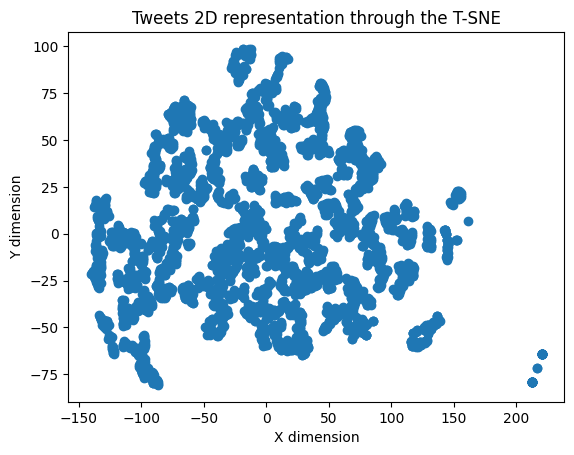

In [35]:
plt.scatter(tweet_vectors_2d[:, 0], tweet_vectors_2d[:, 1])
plt.xlabel('X dimension')
plt.ylabel('Y dimension')
plt.title('Tweets 2D representation through the T-SNE')
plt.show()